# CSAPS

**Cubic spline approximation (smoothing)**

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import csaps


## Univariate data smoothing

Univariate data are two vectors: X and Y with the same size. X is data sites, Y is data values.

For univariate case X-values must satisfy the condition: $x_1 < x_2 < ... < x_N$.

You can use `csaps.UnivariateCubicSmoothingSpline` class for uivariate data smoothing.

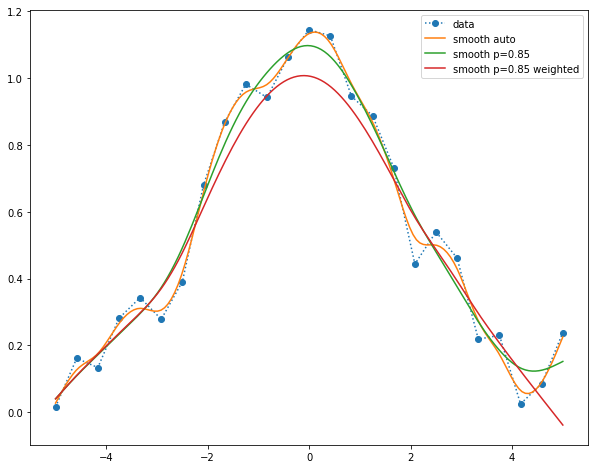

In [2]:
np.random.seed(1234)

x = np.linspace(-5., 5., 25)
y = np.exp(-(x/2.5)**2) + (np.random.rand(25) - 0.2) * 0.3

w = np.ones_like(x)
w[8:16] = 0.1
w[-3:] = 0.01

smooth = 0.85

sp_a = csaps.UnivariateCubicSmoothingSpline(x, y)
sp_s = csaps.UnivariateCubicSmoothingSpline(x, y, smooth=smooth)
sp_w = csaps.UnivariateCubicSmoothingSpline(x, y, w, smooth=smooth)

xi = np.linspace(x[0], x[-1], 150)

yi_a = sp_a(xi)
yi_s = sp_s(xi)
yi_w = sp_w(xi)

fig = plt.figure(figsize=(10, 8))
plt.plot(x, y, 'o:', xi, yi_a, '-', xi, yi_s, '-', xi, yi_w, '-')
plt.legend(['data', 'smooth auto', 'smooth p=0.85', 'smooth p=0.85 weighted']);


### Vectorization

The algorithm supports vectorization. You can compute smoothing splines for 
`X`, `Y` data where `X` is data site vector and `Y` is ND-array of data value vectors. 
The shape of `Y` array must be: `(d0, d1, ..., dN)` where `dN` must equal of `X` vector size.

In this case the smoothing splines will be computed for all `Y` data vectors at a time.

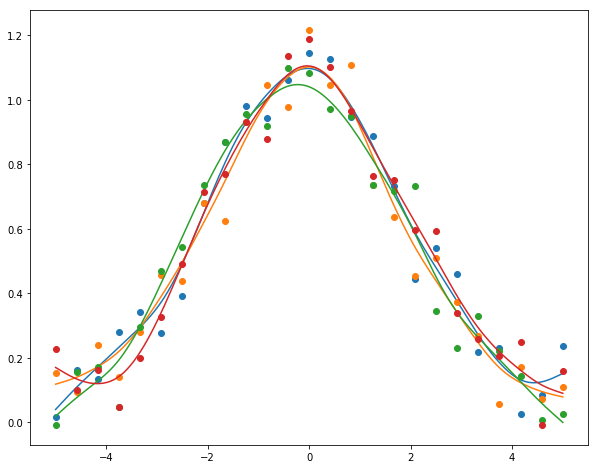

In [3]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color'][:4]

np.random.seed(1234)

x = np.linspace(-5., 5., 25)
y = np.exp(-(x/2.5)**2) + (np.random.rand(len(colors), 25) - 0.2) * 0.3

sp = csaps.UnivariateCubicSmoothingSpline(x, y, smooth=smooth)

xi = np.linspace(x[0], x[-1], 150)
yi = sp(xi)

fig = plt.figure(figsize=(10, 8))

for y_i, yi_i, c_i in zip(y, yi, colors):
    plt.plot(x, y_i, 'o', color=c_i)
    plt.plot(xi, yi_i, '-', color=c_i)


## Natural cubic spline interpolation

We can use smoothing parameter equal to 1.0 to make natural cubic spline interpolant.

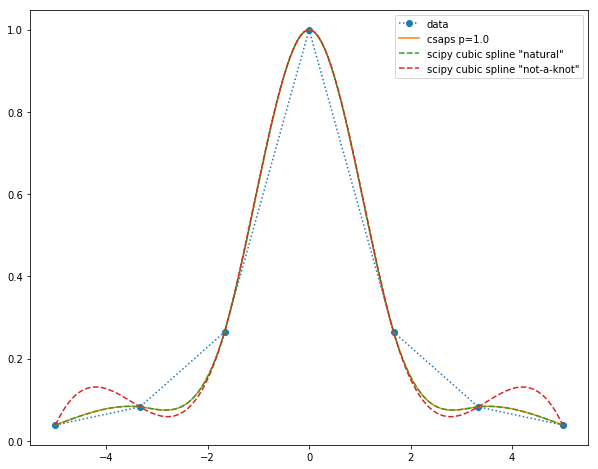

In [4]:
from scipy.interpolate import CubicSpline

x = np.linspace(-5., 5., 7)
y = 1 / (1 + x**2)

xi = np.linspace(x[0], x[-1], 150)

sp = csaps.UnivariateCubicSmoothingSpline(x, y, smooth=1.0)
y_sp = sp(xi)

cs_n = CubicSpline(x, y, bc_type='natural')
y_n = cs_n(xi)

cs_nak = CubicSpline(x, y, bc_type='not-a-knot')
y_nak = cs_nak(xi)

fig = plt.figure(figsize=(10, 8))
plt.plot(x, y, 'o:', xi, y_sp, '-', xi, y_n, '--', xi, y_nak, '--')
plt.legend(['data', 'csaps p=1.0', 'scipy cubic spline "natural"', 'scipy cubic spline "not-a-knot"']);


## Multivariate smoothing



### "Free Hand" 2D-curve smoothing 

Parametric vector $t$ will be computed automatically

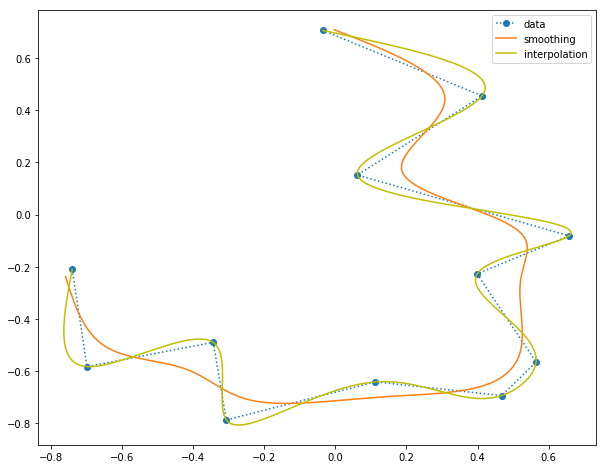

In [5]:
x = [-0.7396, -0.6982, -0.3433, -0.3065,  0.1129,  0.4677,  0.5645,  0.3986,  0.6567, 0.0622, 0.4124, -0.0346]
y = [-0.2099, -0.5831, -0.4898, -0.7872, -0.6414, -0.6939, -0.5656, -0.2274, -0.0816, 0.1516, 0.4548,  0.7055]
data = [x, y]

sp_s = csaps.MultivariateCubicSmoothingSpline(data)
ts = np.linspace(sp_s.t[0], sp_s.t[-1], 200)
ds = sp_s(ts)
xs, ys = ds[0], ds[1]

sp_i = csaps.MultivariateCubicSmoothingSpline(data, smooth=1.0)
ti = np.linspace(sp_i.t[0], sp_i.t[-1], 200)
di = sp_i(ti)
xi, yi = di[0], di[1]

fig = plt.figure(figsize=(10, 8))
plt.plot(x, y, 'o:', xs, ys, '-', xi, yi, '-y');
plt.legend(['data', 'smoothing', 'interpolation']);

### Parametric 3D-curve smoothing

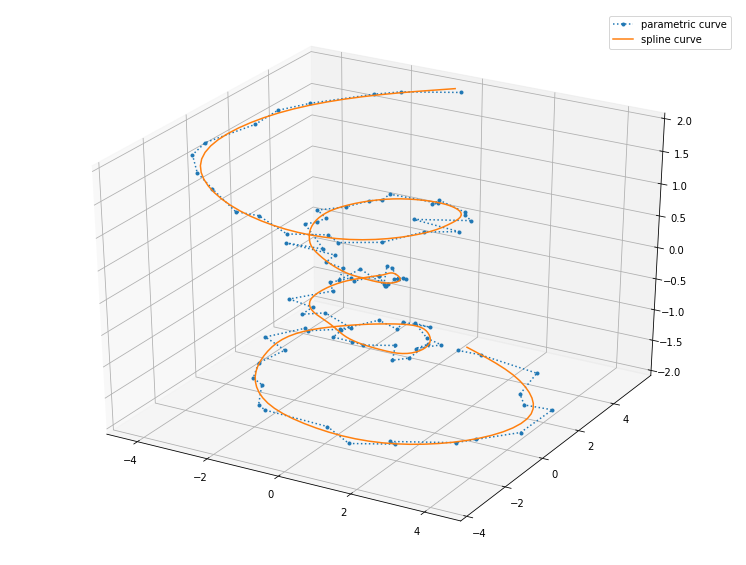

In [6]:
from mpl_toolkits.mplot3d import Axes3D

n = 100
theta = np.linspace(-4 * np.pi, 4 * np.pi, n)
z = np.linspace(-2, 2, n)
r = z**2 + 1
np.random.seed(1234)
x = r * np.sin(theta) + np.random.randn(n) * 0.3
np.random.seed(5678)
y = r * np.cos(theta) + np.random.randn(n) * 0.3

data = np.vstack((x, y, z))

sp_theta = csaps.MultivariateCubicSmoothingSpline(data, theta, smooth=0.95)

theta_i = np.linspace(-4 * np.pi, 4 * np.pi, 250)
data_i = sp_theta(theta_i)

xi = data_i[0,:]
yi = data_i[1,:]
zi = data_i[2,:]

fig = plt.figure(figsize=(13, 10))
ax = fig.gca(projection='3d')
ax.plot(x, y, z, '.:', label='parametric curve')
ax.plot(xi, yi, zi, '-', label='spline curve')
ax.legend();

## ND-gridded data smoothing

The algorithm can make smoothing splines for ND-gridded data approximation.
In this case we use coordinatewise smoothing (tensor-product of univariate splines coefficients).

### Smoothing a surface (2D-grid)


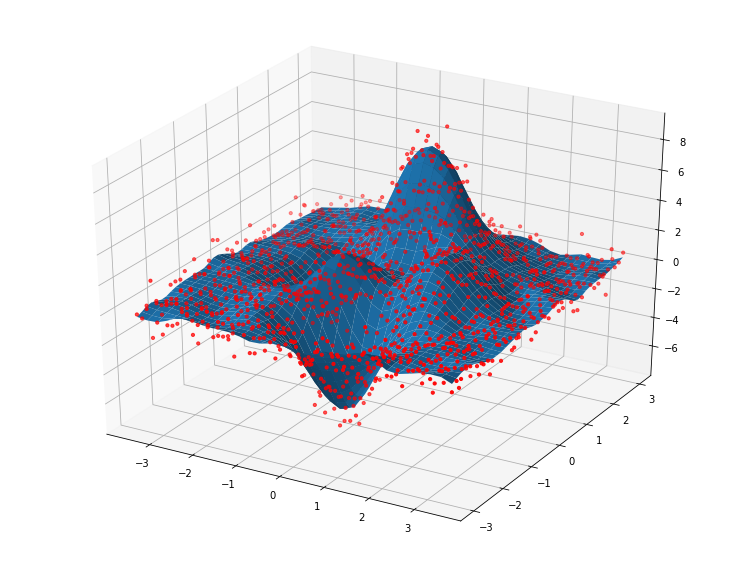

In [7]:
from mpl_toolkits.mplot3d import Axes3D

import csaps

xdata = [np.linspace(-3, 3, 41), np.linspace(-3.5, 3.5, 31)]
i, j = np.meshgrid(*xdata, indexing='ij')

ydata = (3 * (1 - j)**2. * np.exp(-(j**2) - (i + 1)**2)
         - 10 * (j / 5 - j**3 - i**5) * np.exp(-j**2 - i**2)
         - 1 / 3 * np.exp(-(j + 1)**2 - i**2))

np.random.seed(12345)
noisy = ydata + (np.random.randn(*ydata.shape) * 0.75)

sp = csaps.NdGridCubicSmoothingSpline(xdata, noisy, smooth=0.988)
ysmth = sp(xdata)

fig = plt.figure(figsize=(13, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(j, i, noisy, s=10, c='r')
ax.plot_surface(j, i, ysmth, linewidth=0, alpha=1.0);